<font size = "5"> **EDS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [3]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2026.1.1':
    print('installing pyTEMlib')
   
    !{sys.executable} -m pip install pyTEMlib --upgrade
# ------------------------------
print('done')

done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [2]:
%matplotlib widget
import sys
import numpy as np
import matplotlib.pylab as plt

import pyTEMlib

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2026_1_19'

pyTEM version:  0.2026.1.1


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [4]:
# C:\Users\gduscher\OneDrive - University of Tennessee\google_drive\2022 Experiments\Spectra\20221214\AlCe-200kV
fileWidget = pyTEMlib.file_tools.FileWidget()

### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

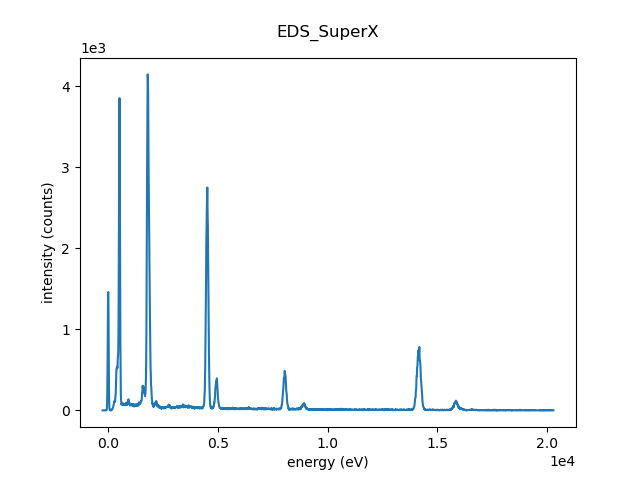

In [5]:
spectrum = fileWidget.selected_dataset
view = spectrum.plot()

In [36]:
### Does not work for spectrum images
# 
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])

spectrum.metadata['EDS']['detector'].setdefault('start_energy',  120)
spectrum.metadata['EDS']['detector']['start_channel'] = np.searchsorted(spectrum.energy_scale.values, spectrum.metadata['EDS']['detector']['start_energy'])
start = spectrum.metadata['EDS']['detector']['start_channel']
spectrum[:spectrum.metadata['EDS']['detector']['start_channel']] = 0.

spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency

## Find Elements 
The minimum_number_of_peaks determines how many elements will be found. 

Increase from 10 to 11 of that parameter will reveal Nb a common dopant of SrTiO$_3$

['Sr', 'Ti', 'Cu', 'O', 'Nb']

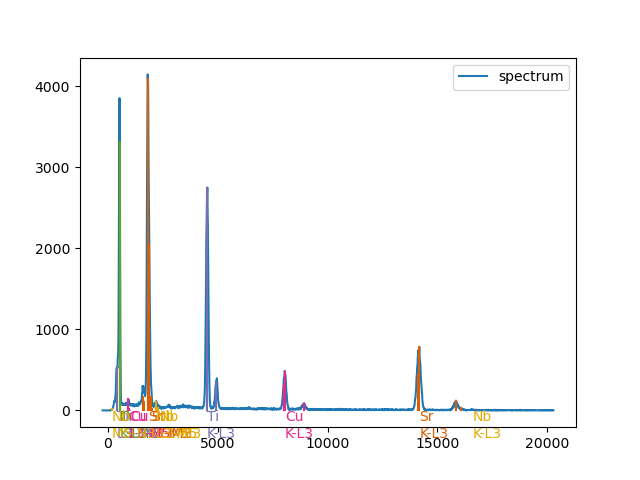

In [39]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------

elements = pyTEMlib.eds_tools.get_elements(spectrum, minimum_number_of_peaks, verbose=False)

plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.legend();
elements

## Quantify

### Fit spectrum

no intensity Nb M-family


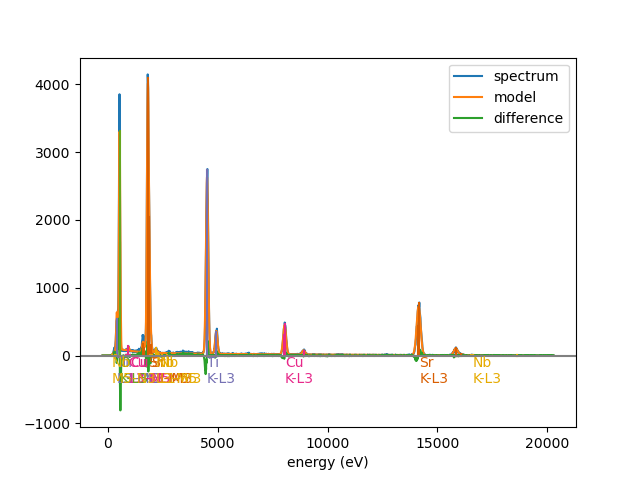

In [47]:
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale.values, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale.values, model, label='model')
plt.plot(spectrum.energy_scale.values, np.array(spectrum)-np.array(model), label='difference')
plt.xlabel('energy (eV)')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend();

### Quantify Spectrum
first with Bote-Salvat cross section
using dictionaries calculated with [emtables package](https://github.com/adriente/emtables/blob/main/).

In [48]:
pyTEMlib.eds_tools.quantify_eds(spectrum, mask =['Cu'])

using cross sections for quantification
Sr: 20.51 at% 45.05 wt%
Ti: 28.35 at% 34.02 wt%
O : 50.91 at% 20.42 wt%
Nb: 0.22 at% 0.52 wt%


then with k-factor dictionary

In [49]:
q_dict = pyTEMlib.eds_tools.load_k_factors()
tags = pyTEMlib.eds_tools.quantify_eds(spectrum, q_dict, mask = ['Cu'])

using k-factors for quantification
Sr: 21.80 at% 48.98 wt%
Ti: 22.43 at% 27.54 wt%
O : 55.46 at% 22.75 wt%
Nb: 0.30 at% 0.73 wt%
excluded from quantification  ['Cu']


### Absorption Correction
Lower energy lines will be more affected than higher x-ray lines.

At thin sample location (<50nm) absorption is not significant.

In [34]:
# ------ Input ----------
thickness_in_nm = 250
# -----------------------
pyTEMlib.eds_tools.apply_absorption_correction(spectrum, thickness_in_nm)
for key, value in spectrum.metadata['EDS']['GUI'].items():
    if 'corrected-atom%' in value:
        print(f"Element: {key}, Corrected Atom%: {value['corrected-atom%']:.2f}, Corrected Weight%: {value['corrected-weight%']:.2f}")

Element: Sr, Corrected Atom%: 19.59, Corrected Weight%: 47.03
Element: Cu, Corrected Atom%: 0.00, Corrected Weight%: 0.00
Element: Ti, Corrected Atom%: 20.29, Corrected Weight%: 26.61
Element: O, Corrected Atom%: 60.12, Corrected Weight%: 26.35


## Summary
The spectrum is modeled completely with background and characteristic peak-families.

Either 
- k-factors in a file (here from Spectra300) or
- Bothe-Salvat cross-sections
 
are used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.
